# Import Library yang Digunakan

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from tensorflow import keras
from tensorflow.keras import layers

# Load kaggle api

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data Understanding

In [5]:
!kaggle datasets download -d nicoletacilibiu/movies-and-ratings-for-recommendation-system -p /kaggle

Dataset URL: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system
License(s): CC0-1.0
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 1.17GB/s]


In [6]:
!unzip /kaggle/movies-and-ratings-for-recommendation-system.zip -d /kaggle

Archive:  /kaggle/movies-and-ratings-for-recommendation-system.zip
  inflating: /kaggle/movies.csv      
  inflating: /kaggle/ratings.csv     


In [7]:
# konversi data movies ke dalam dataframe
movies_df = pd.read_csv('/kaggle/movies.csv', on_bad_lines='skip')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# konversi data ratings ke dalam dataframe
ratings_df = pd.read_csv('/kaggle/ratings.csv', on_bad_lines='skip')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# cek jumlah data
print('Jumlah data movies: ',len(movies_df.movieId.unique()))
print('Jumlah data user: ',len(ratings_df.userId.unique()))

Jumlah data movies:  9742
Jumlah data user:  610


# Univariate Exploratory Data Analysis

## Deskripsi Variabel

In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


insight :
- terdapat 9742 baris data di dalam dataset
- data terdiri dari 3 kolom yaitu : movieId, title, dan genres.
- terdapat 1 data bertipe int64 yaitu kolom movieId, dan 2 kolom bertipe object yaitu kolom title dan genres

In [11]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


insight :
- terdapat 100836 baris data di dalam dataset.
- data terdiri dari 4 kolom yaitu : userId, movieId, rating, dan timestamp.
- terdapat 3 kolom bertipe int64, yaitu kolom userId, movieId, dan timestamp. terdapat 1 kolom bertipe float yaitu kolom rating.

## Memeriksa Missing Value

In [12]:
missing_values_movie = movies_df.isnull().sum()
print('jumlah missing value pada data movie: ', missing_values_movie)

missing_values_rating = ratings_df.isnull().sum()
print('jumlah missing value pada data rating: ', missing_values_rating)

jumlah missing value pada data movie:  movieId    0
title      0
genres     0
dtype: int64
jumlah missing value pada data rating:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Memeriksa Outlier

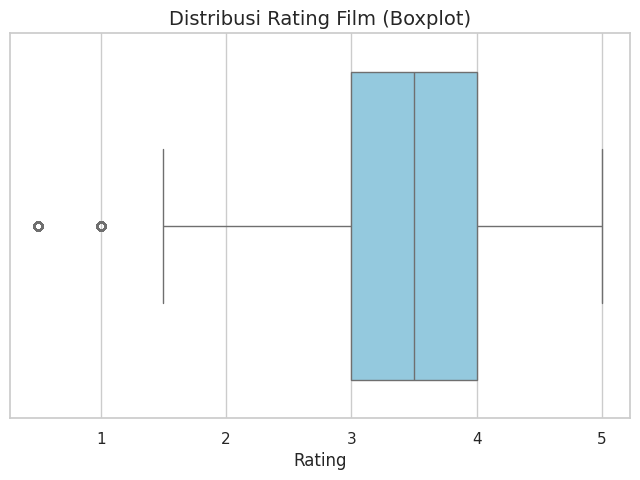

In [13]:
sns.set(style="whitegrid")

# Buat figure boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=ratings_df['rating'], color='skyblue')

# Judul dan label
plt.title('Distribusi Rating Film (Boxplot)', fontsize=14)
plt.xlabel('Rating')

# Tampilkan plot
plt.show()

## Memeriksa data duplikat

In [14]:
# jumlah data duplikat pada data movie
jumlah_duplikat_movie = movies_df.duplicated().sum()
print('Jumlah data duplikat pada data movie: ', jumlah_duplikat_movie)

# jumlah data duplikat pada data rating
jumlah_duplikat_rating = ratings_df.duplicated().sum()
print('Jumlah data duplikat pada data rating', jumlah_duplikat_rating)

Jumlah data duplikat pada data movie:  0
Jumlah data duplikat pada data rating 0


## Univariate Analysis

In [15]:
# cek daftar genre
all_genres = movies_df['genres'].str.split('|').explode()

unique_genres = all_genres.unique()
print('Jumlah genre unik:', len(unique_genres))
print('Daftar genre unik:')
for genre in unique_genres:
    print('-', genre)

Jumlah genre unik: 20
Daftar genre unik:
- Adventure
- Animation
- Children
- Comedy
- Fantasy
- Romance
- Drama
- Action
- Crime
- Thriller
- Horror
- Mystery
- Sci-Fi
- War
- Musical
- Documentary
- IMAX
- Western
- Film-Noir
- (no genres listed)


Genre terbanyak:

genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


<ipython-input-16-2f9d20bda529>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


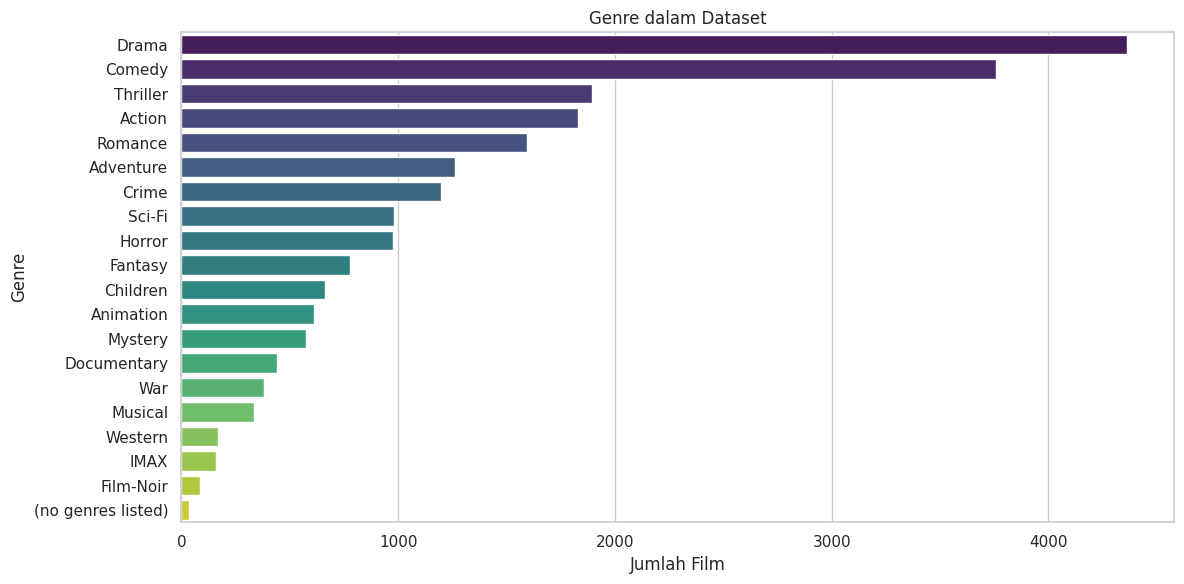

In [16]:
# Visualisasi jumlah genre
genre_counts = all_genres.value_counts()

# Tampilkan  genre terbanyak
print("Genre terbanyak:\n")
print(genre_counts)
# Visualisasi dengan barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')

plt.title('Genre dalam Dataset')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

<ipython-input-17-e2278c8c5e71>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='viridis')


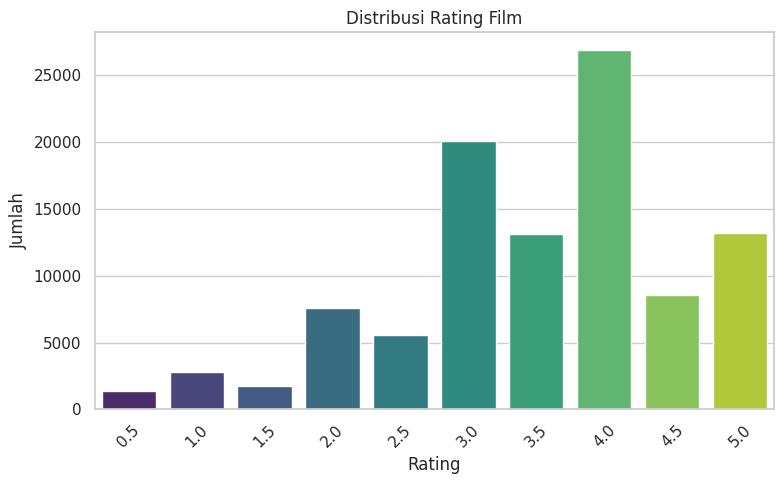

In [17]:
# visualisasi persebaran ratings
sns.set(style="whitegrid")

# Ukuran figure
plt.figure(figsize=(8, 5))

# Plot distribusi rating
sns.countplot(x='rating', data=ratings_df, palette='viridis')

# Tambahkan judul dan label
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Rotasi label jika perlu

# Tampilkan plot
plt.tight_layout()
plt.show()

In [18]:
print('Jumlah userId: ', len(ratings_df.userId.unique()))
print('Jumlah movieId: ', len(ratings_df.movieId.unique()))
print('Jumlah data ratings: ', len(ratings_df))

Jumlah userId:  610
Jumlah movieId:  9724
Jumlah data ratings:  100836


# Data Preprocessing

## Data movie

In [19]:
# membuat salinan dari data movies_df
fix_movie = movies_df.copy()

In [20]:
# mengonversi setiap data series 'movieId' menjadi bentuk list
moviesId = fix_movie['movieId'].tolist()

# mengonversi data 'title' menjadi bentuk list
title = fix_movie['title'].tolist()

# mengonversi data 'genres' menjadi bentuk list
genres = fix_movie['genres'].tolist()

print(len(moviesId))
print(len(title))
print(len(genres))

9742
9742
9742


In [21]:
# Membuat dictionary untuk data ‘moviesId’, ‘title’, dan ‘genres’
movies_new = pd.DataFrame({
    'moviesId': moviesId,
    'title': title,
    'genres': genres
})
movies_new

,moviesId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Data rating

In [22]:
ratings_new = ratings_df.drop(columns=['timestamp'])
ratings_new.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [23]:
# encoding kolom userId
userIds = ratings_new['userId'].unique().tolist()
print('list userIds:', userIds)

user_to_user_encoded = {x: i for i, x in enumerate(userIds)}
print('encoded userIds : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(userIds)}
print('encoded angka ke userIds: ', user_encoded_to_user)

list userIds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [24]:
# encoding kolom movieId
movieIds = ratings_new['movieId'].unique().tolist()
print('list movieIds:', movieIds)

movie_to_movie_encoded = {x: i for i, x in enumerate(movieIds)}
print('encoded movieID : ', movie_to_movie_encoded)

movie_encoded_to_movie = {i: x for i, x in enumerate(movieIds)}
print('encoded angka ke movieID: ', movie_encoded_to_movie)

list movieIds: [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 2641

In [25]:
# menentukan jumlah user di dalam data ratings
num_users = len(userIds)
print('jumlah user:', num_users)

# menentukan jumlah film di dalam data ratings
num_movies = len(movieIds)
print('jumlah movie:', num_movies)

ratings_df['rating'] = ratings_df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(ratings_new['rating'])
max_rating = max(ratings_new['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

jumlah user: 610
jumlah movie: 9724
Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


In [26]:
# mengacak kolom ratings
ratings_new = ratings_new.sample(frac=1, random_state=42)
ratings_new

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


In [27]:
# Mapping userID ke dataframe user
ratings_new['user'] = ratings_new['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
ratings_new['movie'] = ratings_new['movieId'].map(movie_to_movie_encoded)

X = ratings_new[['user', 'movie']]
y = ratings_new['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * ratings_new.shape[0])
X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(X, y)

       user  movie
67037   431   4730
42175   287    474
93850   598   2631
6187     41    194
12229    74    727
...     ...    ...
6265     41   1873
54886   363    524
76820   479   2240
860       5    712
15795   102   2046

[100836 rows x 2 columns] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


# Model Deployment

## Model Content Based Filtering


In [28]:
# membuat salinan dari data movies
data_movies = movies_df

### TF_IDF Vectorizer

In [29]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(data_movies['genres'])

tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [30]:
tfidf_matrix.shape

(9742, 23)

In [31]:
tfidf_matrix.todense()

matrix([[0.        , 0.41684567, 0.51622547, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51236121, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57860574, 0.        , 0.81560738, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [32]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data_movies['title']
).sample(22, axis=1).sample(10, axis=0)

,comedy,mystery,documentary,adventure,noir,film,romance,listed,western,animation,...,action,thriller,horror,sci,genres,fantasy,drama,fi,war,crime
title,,,,,,,,,,,,,,,,,,,,,
They Call Me Bruce? (a.k.a. A Fistful of Chopsticks) (1982),1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Maidens in Uniform (Mädchen in Uniform) (1931),0.000000,0.0,0.0,0.000000,0.0,0.0,0.841423,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.540377,0.000000,0.000000,0.0
Gallipoli (1981),0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.391730,0.000000,0.920080,0.0
Tom Segura: Mostly Stories (2016),1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Big Wednesday (1978),0.734632,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.678466,0.000000,0.000000,0.0
"Apple, The (Sib) (1998)",0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0
Watch on the Rhine (1943),0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0
Ernest Saves Christmas (1988),0.468319,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Soldier (1998),0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.390641,0.0,0.0,0.481689,0.0,0.000000,0.000000,0.481689,0.619154,0.0


### Cek Cosine Similarity

In [33]:
# menggunakan subset 1000 film pertama untuk menghemat ram
tfidf_sample = tfidf_matrix[:1000]
cosine_sim_sample = cosine_similarity(tfidf_sample)
cosine_sim_sample

array([[1.        , 0.81357774, 0.15276924, ..., 0.        , 0.19657754,
        0.        ],
       [0.81357774, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15276924, 0.        , 1.        , ..., 0.        , 0.41941262,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.26577546,
        0.14137207],
       [0.19657754, 0.        , 0.41941262, ..., 0.26577546, 1.        ,
        0.2448527 ],
       [0.        , 0.        , 0.        , ..., 0.14137207, 0.2448527 ,
        1.        ]])

In [34]:
cosine_sim_df = pd.DataFrame(
    cosine_sim_sample,
    index=data_movies['title'][:1000],
    columns=data_movies['title'][:1000]
)

print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1000, 1000)


title,"Walking Dead, The (1995)",North by Northwest (1959),Giant (1956),"African Queen, The (1951)",Blown Away (1994)
title,,,,,
Gigi (1958),0.000000,0.000000,0.000000,0.000000,0.000000
Mortal Kombat (1995),0.000000,0.450733,0.000000,0.276390,0.354360
"Streetcar Named Desire, A (1951)",0.391730,0.000000,0.297531,0.000000,0.000000
Richie Rich (1994),0.000000,0.000000,0.000000,0.146635,0.000000
"Day the Earth Stood Still, The (1951)",0.125031,0.181634,0.094965,0.000000,0.327805
Jumanji (1995),0.000000,0.230015,0.000000,0.249911,0.000000
Othello (1995),0.391730,0.000000,0.297531,0.000000,0.000000
"Return of the Pink Panther, The (1975)",0.000000,0.000000,0.000000,0.167118,0.000000
True Lies (1994),0.000000,0.778644,0.219752,0.567480,0.634188


In [35]:
# Fungsi rekomendasi film berdasarkan cosine similarity
def movie_recommendations(title, similarity_data=cosine_sim_df, items=data_movies[['title', 'genres']], k=5):
    index = similarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [36]:
data_movies[data_movies.title.eq('Jumanji (1995)')]

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [37]:
movie_recommendations('Jumanji (1995)')

,title,genres
0,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy
1,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
2,Escape to Witch Mountain (1975),Adventure|Children|Fantasy
3,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Model Collaborative Filtering

In [38]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [39]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [40]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (X_val, y_val)
)

Epoch 1/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 0.6458 - root_mean_squared_error: 0.2411 - val_loss: 0.6132 - val_root_mean_squared_error: 0.2066
Epoch 2/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 0.6055 - root_mean_squared_error: 0.1993 - val_loss: 0.6091 - val_root_mean_squared_error: 0.2019
Epoch 3/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.6013 - root_mean_squared_error: 0.1931 - val_loss: 0.6081 - val_root_mean_squared_error: 0.2007
Epoch 4/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5968 - root_mean_squared_error: 0.1896 - val_loss: 0.6075 - val_root_mean_squared_error: 0.1999
Epoch 5/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.5959 - root_mean_squared_error: 0.1874 - val_loss: 0.6068 - val_root_mean_squared_error: 0.1990
Epoch 6/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5948 - root_mean_squared_error: 0.1862 - val_loss: 0.6067 - val_root_mean_squared_error: 0.1988
Epoch 7/100
1008

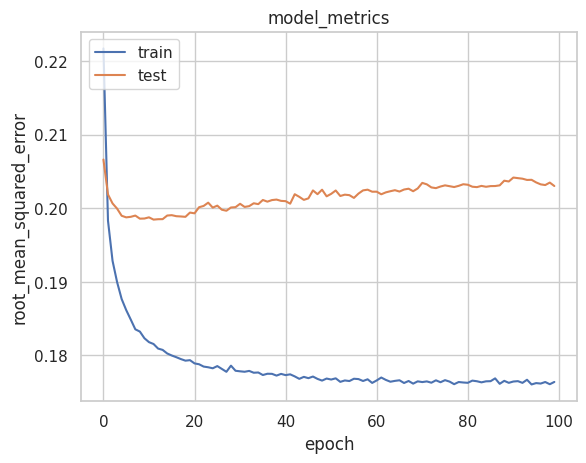

In [41]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# Mengambil satu sample user secara acak
user_id = ratings_df['userId'].sample(1).iloc[0]

# mengambil film yang sudah dirating oleh user ini
movies_watched_by_user = ratings_df[ratings_df.userId == user_id]

# mengambil film yang belum ditonton oleh user ini
movies_not_watched = movies_df[~movies_df['movieId'].isin(movies_watched_by_user.movieId.values)]

# Hanya ambil movieId yang ada di kamus encoding
movies_not_watched = list(
    set(movies_not_watched.movieId.values)
    .intersection(set(movie_to_movie_encoded.keys()))
)

# Encoding movieId
movies_not_watched_encoded = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]

# Encoding userId
user_encoded = user_to_user_encoded.get(user_id)

# membuat array pasangan user dan semua film yang belum ditonton
user_movie_array = np.hstack(
    (
        np.array([[user_encoded]] * len(movies_not_watched_encoded)),
        np.array(movies_not_watched_encoded)
    )
)

In [45]:
ratings = model.predict(user_movie_array).flatten()

# Ambil indeks top-N prediksi tertinggi
top_indices = ratings.argsort()[-10:][::-1]  # top 10

# Ambil movieId-nya kembali dari encoded
recommended_movie_ids = [
    movie_encoded_to_movie[i[0]] for i in np.array(movies_not_watched_encoded)[top_indices]
]

# Tampilkan judul film rekomendasi
recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
print(recommended_movies[['movieId', 'title','genres']])

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      movieId                                              title  \
87         99               Heidi Fleiss: Hollywood Madam (1995)   
883      1178                              Paths of Glory (1957)   
2597     3473  Jonah Who Will Be 25 in the Year 2000 (Jonas q...   
3608     4956                              Stunt Man, The (1980)   
4390     6442                                Belle époque (1992)   
4396     6460                     Trial, The (Procès, Le) (1962)   
4782     7121                                  Adam's Rib (1949)   
5580    26810                               Bad Boy Bubby (1993)   
7364    78836                              Enter the Void (2009)   
9497   170705                            Band of Brothers (2001)   

                                              genres  
87                                       Documentary  
883                                        Drama|War  
2597                                         